### FURB - UNIVERSIDADE REGIONAL DE BLUMENAU


Especialização em Data Science - Turma 2

Disciplina: Chatbots

Professor: Cristiano Roberto Franco

**Aluno: Marcus Moresco Boeno**

In [4]:

# Carrega bibliotecas Built-in
import re
import os
import sys
import time
import configparser
from datetime import date

# Carrega bibliotecas de terceiros
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from ibm_watson import AssistantV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator


### Conexão com o IBM Watson Assistant

A conexão com o watson assitant se dá pela API Watson Assistant v1 

(https://cloud.ibm.com/apidocs/assistant/assistant-v1)

In [8]:

# Realizando leitura de IDS e Keys do IBM Watson Assistant
config = configparser.ConfigParser()
config.read_file(open(r"watson_api_key.cfg"))
WAS_WORKSPACE = config.get('api-keys', 'WAS_WORKSPACE')
WAS_API_KEY = config.get('api-keys', 'WAS_API_KEY')
WAS_URL = config.get('api-keys', 'WAS_URL')


In [9]:

# Cria assitente e autenticação
authenticator = IAMAuthenticator(WAS_API_KEY)
assistant = AssistantV1(
    version='2020-04-01',
    authenticator=authenticator
)

# Cria serviço
assistant.set_service_url(WAS_URL)
original_workspace_id = WAS_WORKSPACE



### Checando status do serviço

In [10]:

def check_wksp_status(check_workspace_id):
    wksp_notready = True
    
    while(wksp_notready == True):
        print('Testando Workspace...' + check_workspace_id)
        workspace = assistant.get_workspace(workspace_id=check_workspace_id, export=True).get_result()

        print('Workspace status: {0}'.format(workspace['status']))
        if workspace['status'] == 'Available':
            wksp_notready = False
            print('Pronto para conexão!')
        else:
            print('No momento estou em treinamento...espere 30 segundos e tente novamente.')
            time.sleep(30)



In [11]:
check_wksp_status(original_workspace_id)

Testando Workspace...f55b4544-a053-4e67-b5cb-cded7704f38c
Workspace status: Available
Pronto para conexão!


In [12]:

def get_watson_conversations_log(workspace_id):
    """Function to return list with conversation logs
    """
    # Recupera log de conversas
    response = assistant.list_logs(
        workspace_id = workspace_id, 
        page_limit = 100
    ).get_result()

    # Cria lista vazia para armazenar logs
    watson_conversation_log = []

    # Cria cursor regex
    cursor_regex = r".*?cursor=(.*?)&"

    # Separa dicionarios de logs e de paginacao
    logs = response['logs']
    page = response['pagination']

    # Loop enquanto ainda houver dados a coletar
    while response:
        
        # Itera sobre logs
        for log in logs:

            # Armazena logs na lista
            watson_conversation_log.append(log)
    
        # Checa paginacao
        if not page: #'pagination' not in response or 'next_url' not in response['pagination']:
            break
        
        # Atualiza link do cursor
        cursor_res = re.search(cursor_regex, page['next_url'], re.IGNORECASE)
        cursor = None
        
        if cursor_res:
            cursor = cursor_res.group(1)
        if not cursor:
            break

        # Recupera logs para pagina seguinte 
        response = assistant.list_logs(
            workspace_id=workspace_id, 
            page_limit=100, 
            cursor=cursor
        ).get_result()
        
        # Atualiza dicionarios de logs e de paginacao
        logs = response['logs']
        page = response['pagination']

    # Retorna lista com logs
    return watson_conversation_log


In [13]:

# Recupera logs de conversas
logs_watson = get_watson_conversations_log(original_workspace_id)


In [14]:

def get_intent(log):
    """Function to get intent
    """
    if len(log['response']['intents']) == 0:
        return np.nan
    else:
        return log['response']['intents'][0]['intent']

def get_intent_conf(log):
    """Function to get intent confidence
    """
    if len(log['response']['intents']) == 0:
        return np.nan
    else:
        return log['response']['intents'][0]['confidence']

# Cria pd.DataFrame com métricas de interesse
was_metrics = pd.DataFrame()
was_metrics['raw_logs'] = logs_watson
was_metrics['conversation_ids'] = [log['response']['context']['conversation_id'] for log in logs_watson]
was_metrics['timestamps'] = [log['request_timestamp'] for log in logs_watson]
was_metrics = was_metrics.assign(iso_date = was_metrics.timestamps.apply(lambda x: date.fromisoformat(x[:10])))
was_metrics = was_metrics.assign(intent = was_metrics.raw_logs.apply(get_intent))
was_metrics = was_metrics.assign(intent_conf = was_metrics.raw_logs.apply(get_intent_conf))

was_metrics.head()

,raw_logs,conversation_ids,timestamps,iso_date,intent,intent_conf
0,"{'request': {'suggestion_only': 'false', 'cont...",99be70e8-c41c-49f2-956f-075322418703,2021-05-14T19:33:55.835Z,2021-05-14,saudacao,0.437598
1,"{'request': {'suggestion_only': 'false', 'cont...",99be70e8-c41c-49f2-956f-075322418703,2021-05-14T19:34:09.970Z,2021-05-14,NaN,NaN
2,"{'request': {'suggestion_only': 'false', 'cont...",99be70e8-c41c-49f2-956f-075322418703,2021-05-14T19:32:19.942Z,2021-05-14,consultar_precos,1.000000
3,"{'request': {'suggestion_only': 'false', 'cont...",99be70e8-c41c-49f2-956f-075322418703,2021-05-14T19:32:37.420Z,2021-05-14,reservar_voo,0.938291
4,"{'request': {'suggestion_only': 'false', 'cont...",99be70e8-c41c-49f2-956f-075322418703,2021-05-14T19:32:55.624Z,2021-05-14,NaN,NaN


# Construção de Indicadores

In [15]:

# Total de conversas
print("")
print(f"Total de Conversas: {len(was_metrics.conversation_ids.unique())}")
print("")
# Total de mensagens
print(f"Total de Mensagens Recebidas: {len(was_metrics.iso_date)}")
print("")



Total de Conversas: 73

Total de Mensagens Recebidas: 328



In [16]:
# Total de conversas por dia
convs, days = [], []
for dt in was_metrics.iso_date.unique():
    
    # Filtra database por data
    df_tmp = was_metrics[was_metrics.iso_date == dt]
    
    # Recupera numero de conversas por dia
    convs.append(len(df_tmp.conversation_ids.unique()))
    days.append(dt)

print(f"Número total de conversas por dia: {[days, convs]}")


# Total de mensagens por dia
msgs, days = [], []
for dt in was_metrics.iso_date.unique():
    
    # Filtra database por data
    df_tmp = was_metrics[was_metrics.iso_date == dt]
    
    # Recupera numero de conversas por dia
    msgs.append(len(df_tmp))
    days.append(dt)

print(f"Número total de mensagens por dia: {[days, msgs]}")

Número total de conversas por dia: [[datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 16), datetime.date(2021, 5, 17)], [16, 46, 10, 2]]
Número total de mensagens por dia: [[datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 16), datetime.date(2021, 5, 17)], [56, 179, 85, 8]]


In [27]:

def make_bar_plot(series, xlab, ylab, title, text_dist, ylim=None):
    """Função para criar bar plot
    """
    # Set default figure size.
    plt.rcParams['figure.figsize'] = (20, 7)

    # Cria objetos graficos
    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(series.size),
        height=series,
        tick_label=series.index.values,
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Grab the color of the bars so we can make the
    # text the same color.
    bar_color = bars[0].get_facecolor()

    # Add text annotations to the top of the bars.
    # Note, you'll have to adjust this slightly (the 0.3)
    # with different data.
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + text_dist,
            round(bar.get_height(), 3),
            horizontalalignment='center',
            color=bar_color,
            weight='bold'
        )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_xlabel(xlab, labelpad=15, color='#333333')
    ax.set_ylabel(ylab, labelpad=15, color='#333333')
    ax.set_title(title, pad=15, color='#333333', weight='bold')

    # Checa se limites para o eixo y foram especificados
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # Indica layout da figura
    fig.tight_layout()


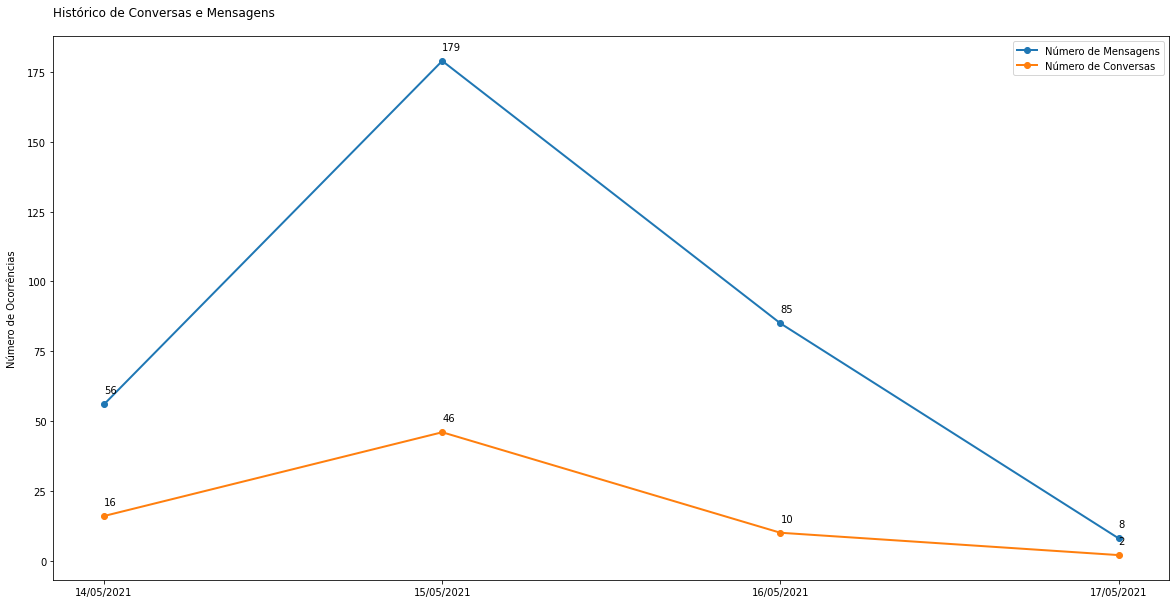

In [24]:
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams["figure.figsize"] = (20,10)
days_tmp = [day.strftime("%d/%m/%Y") for day in days] 
plt.plot(days_tmp, msgs, marker='o', label = "Número de Mensagens")
plt.plot(days_tmp, convs, marker='o', label = "Número de Conversas")
plt.ylabel("Número de Ocorrências", labelpad=10)
plt.title("Histórico de Conversas e Mensagens", loc = "left", pad=20)
plt.legend()

# Adiciona valores nos marcadores
for a,b in zip(days_tmp, convs): plt.text(a, b + 4, str(b))
for a,b in zip(days_tmp, msgs): plt.text(a, b + 4, str(b))

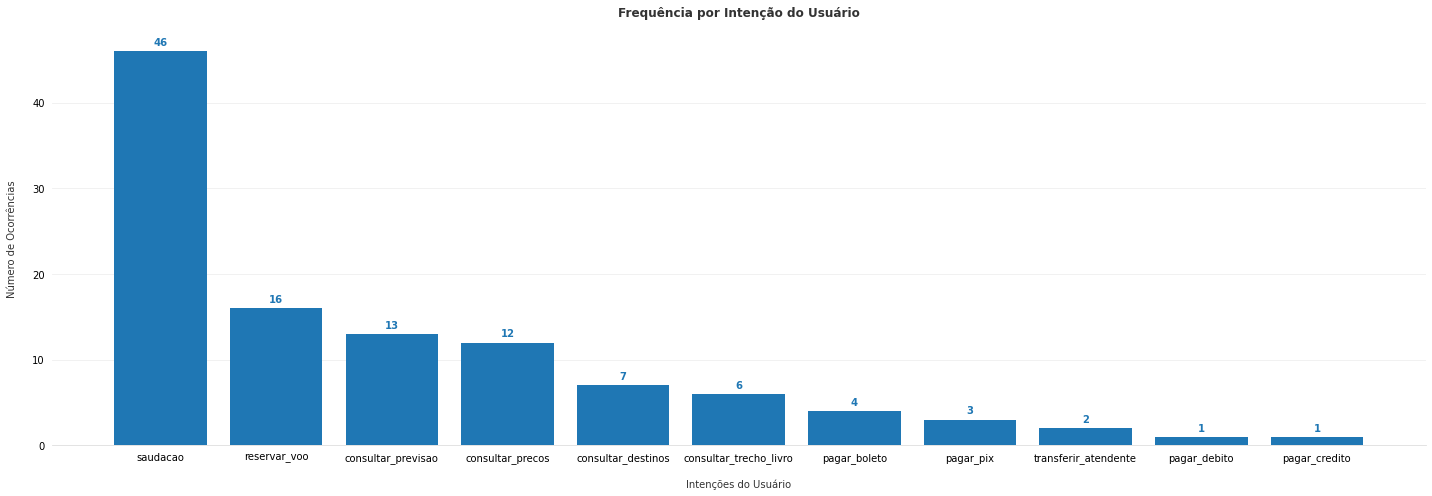

In [28]:

# Recupera info de frequência das intenções
freq_intent = was_metrics.groupby('intent').count().intent_conf.sort_values(ascending=False)

# Cria grafico de barras indicando número de ocorrência das intenções
make_bar_plot(
    series=freq_intent, 
    xlab='Intenções do Usuário', 
    ylab='Número de Ocorrências', 
    title='Frequência por Intenção do Usuário',
    text_dist=0.7
)


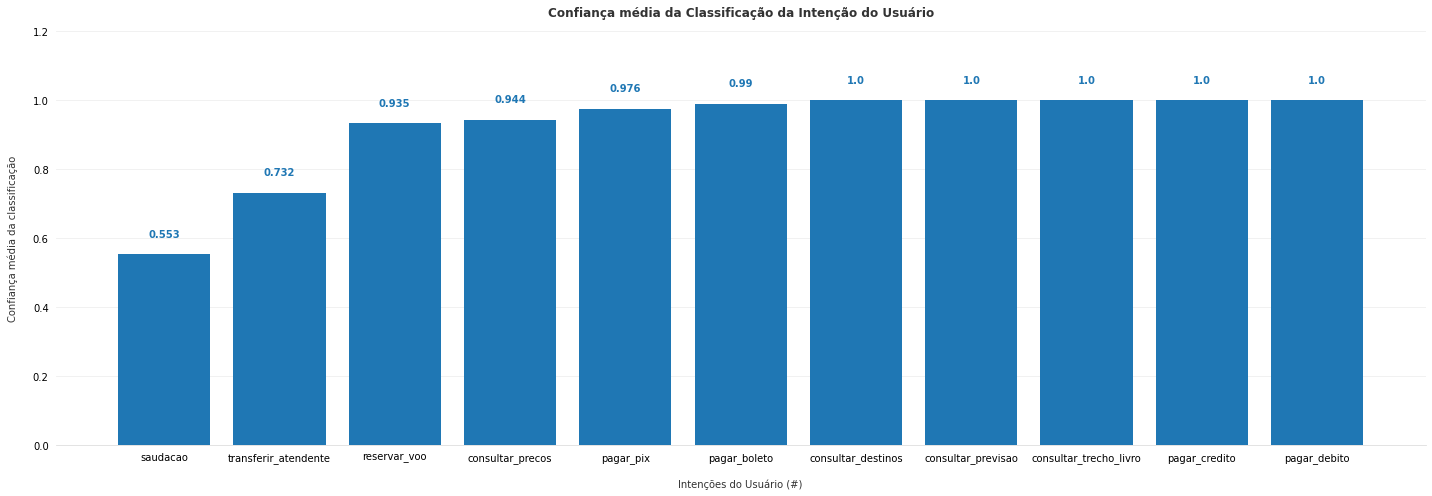

In [29]:

# Recupera info de frequência das intenções
mean_intent_conf = was_metrics.groupby('intent').mean().intent_conf.sort_values()

# Cria grafico de barras indicando número de ocorrência das intenções
make_bar_plot(
    series=mean_intent_conf, 
    xlab='Intenções do Usuário (#)', 
    ylab='Confiança média da classificação', 
    title='Confiança média da Classificação da Intenção do Usuário', 
    text_dist=0.05,
    ylim=[0, 1.2]
)
